In [2]:
import pandas as pd
import hopsworks
import joblib
import os

project = hopsworks.login(api_key_value=os.getenv("HOPSWORKS_PYTHON_CLIKEY"))
fs = project.get_feature_store()

2025-03-09 00:06:13,046 INFO: Initializing external client
2025-03-09 00:06:13,047 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-09 00:06:13,745 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214673


In [4]:
mr = project.get_model_registry()
model = mr.get_model("iris", version=1)
model_dir = model.download()
model = joblib.load(model_dir + "/model.pkl")

In [31]:
feature_view = fs.get_feature_view(name="iris", version=1)

In [32]:
import datetime
from PIL import Image

batch_data = feature_view.get_batch_data()

y_pred = model.predict(batch_data)

y_pred

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.44s) 


array(['Setosa', 'Versicolor', 'Virginica', 'Versicolor', 'Setosa',
       'Versicolor', 'Virginica', 'Versicolor', 'Setosa', 'Setosa',
       'Setosa', 'Setosa', 'Versicolor', 'Virginica', 'Setosa',
       'Virginica', 'Versicolor', 'Setosa', 'Versicolor', 'Versicolor',
       'Setosa', 'Versicolor', 'Setosa', 'Setosa', 'Versicolor',
       'Versicolor', 'Virginica', 'Virginica', 'Virginica', 'Versicolor',
       'Versicolor', 'Setosa', 'Setosa', 'Virginica', 'Setosa',
       'Virginica', 'Setosa', 'Versicolor', 'Virginica', 'Versicolor',
       'Virginica', 'Setosa', 'Versicolor', 'Virginica', 'Versicolor',
       'Setosa', 'Versicolor', 'Versicolor', 'Virginica', 'Setosa',
       'Setosa', 'Virginica', 'Virginica', 'Versicolor', 'Versicolor',
       'Virginica', 'Versicolor', 'Versicolor', 'Versicolor', 'Setosa',
       'Virginica', 'Virginica', 'Virginica', 'Setosa', 'Virginica',
       'Setosa', 'Versicolor', 'Versicolor', 'Setosa', 'Setosa', 'Setosa',
       'Versicolor', 'Virgin

In [ ]:
flower = y_pred[y_pred.size-1]
flower_img = "./assets/" + flower + ".png"
img = Image.open(flower_img)            

img.save("./assets/latest_iris.png")

In [34]:
iris_fg = fs.get_feature_group(name="iris", version=1)
df = iris_fg.read()
df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.29s) 


,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.700000,3.800000,1.700000,0.300000,Setosa
1,5.600000,2.700000,4.200000,1.300000,Versicolor
2,6.300000,3.300000,6.000000,2.500000,Virginica
3,6.000000,2.900000,4.500000,1.500000,Versicolor
4,5.000000,3.000000,1.600000,0.200000,Setosa
...,...,...,...,...,...
147,6.400000,2.800000,5.600000,2.100000,Virginica
148,5.000000,3.400000,1.600000,0.400000,Setosa
149,5.367117,4.434446,1.374910,0.497858,Setosa
150,6.245449,2.706324,6.821494,1.801524,Virginica


In [ ]:
label = df.iloc[-1]["variety"]
label

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


'Virginica'

In [41]:
label_flower = "assets/" + label + ".png"
img = Image.open(label_flower)            
img.save("./assets/actual_iris.png")

In [11]:
import pandas as pd

monitor_fg = fs.get_or_create_feature_group(
    name="iris_predictions",
    version=1,
    primary_key=["datetime"],
    description="Iris flower Prediction/Outcome Monitoring"
    )

In [43]:
from datetime import datetime
now = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")

data = {
    'prediction': [flower],
    'label': [label],
    'datetime': [now],
}

monitor_df = pd.DataFrame(data)
monitor_fg.insert(monitor_df)

Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: iris_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1214673/jobs/named/iris_predictions_1_offline_fg_materialization/executions


(Job('iris_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [44]:
history_df = monitor_fg.read()
history_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.11s) 


,prediction,label,datetime
0,Setosa,Setosa,"03/09/2025, 00:23:56"
1,Setosa,Setosa,"03/09/2025, 00:36:45"
2,Versicolor,Versicolor,"03/09/2025, 00:49:30"
3,Virginica,Virginica,"03/09/2025, 00:55:29"


In [45]:
import dataframe_image as dfi

df_recent = history_df.tail(5)
 
# If you exclude this image, you may have the same iris_latest.png and iris_actual.png files
# If no files have changed, the GH-action 'git commit/push' stage fails, failing your GH action (last step)
# This image, however, is always new, ensuring git commit/push will succeed.
dfi.export(df_recent, './assets/df_recent.png', table_conversion = 'matplotlib')

In [46]:
from sklearn.metrics import confusion_matrix

predictions = history_df[['prediction']]
labels = history_df[['label']]

results = confusion_matrix(labels, predictions)
print(results)

[[2 0 0]
 [0 1 0]
 [0 0 1]]


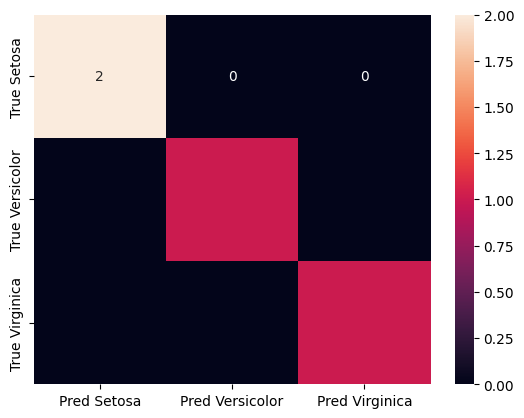

In [47]:
from matplotlib import pyplot
import seaborn as sns

# Only create the confusion matrix when our iris_predictions feature group has examples of all 3 iris flowers
if results.shape == (3,3):

    df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
                         ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])

    cm = sns.heatmap(df_cm, annot=True)

    fig = cm.get_figure()
    fig.savefig("./assets/inference_confusion_matrix.png") 
    df_cm
else:
    print("Run the batch inference pipeline more times until you get 3 different iris flowers") 